Métodos Numéricos para resolução do Pêndulo Duplo

    Este é um código desenvolvido para calcular a trajetória de um pêndulo duplo a partir do Método de Euler e Runge-Kutta.

    No código é possível variar as condições iniciais do sistema, o passo (h) e a tolerância de erro do Runge-Kutta

In [1]:
# Importa todas as bibliotecas necessárias para o código
# Aumenta o limite das animações do pêndulo

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import ticker
matplotlib.rcParams['animation.embed_limit'] = 21094993
%matplotlib inline


In [2]:
######################
# CONDIÇÕES INICIAIS #
######################

g = 10 # em m/s²
m1 = 1 # em kg
m2 = 0.5 # em kg
theta1 = math.radians(45) # em radianos
theta2 = math.radians(45) # em radianos
omega1= 0 # em rad/s
omega2= 0 # em rad/s
l1 = 1 # em m
l2 = 1 # em m

theta10 = theta1
theta20 = theta2

# A linha abaixo define o vetor de estado inicial do sistema
y0 = np.array([theta1, theta2, omega1, omega2], dtype = float)


In [3]:
#####################################
# DEFINIÇÃO DE FUNÇÕES DA SIMULAÇÃO #
#####################################

# A função F(t,y) calcula a velocidade e aceleração angular em cada iteração
# Esse dados são utilizados para calcular a posição angular em cada iteração
# As funções da aceleração angular surgem da solução Lagrangiana do pêndulo duplo
def F(t, y):
    theta1, theta2, omega1, omega2 = y
    delta = theta1 - theta2

    D = 2*m1 + m2 - m2*math.cos(2*delta)

    theta1dd = (
        -g*(2*m1 + m2) * math.sin(theta1)
        - m2 * g * math.sin(theta1 - 2*theta2)   
        - 2 * math.sin(delta) * m2 * (l2 * omega2**2 + l1 * omega1**2 * math.cos(delta))
    ) / (l1 * D)

    theta2dd = (
        2 * math.sin(delta) * (
            omega1**2 * l1 * (m1 + m2)
            + g * (m1 + m2) * math.cos(theta1)
            + omega2**2 * l2 * m2 * math.cos(delta)
        )
    ) / (l2 * D)

    return np.array([omega1, omega2, theta1dd, theta2dd], dtype=float)


# Calcula a Energia Cinética e Potencial do sistem para cada iteração
def energia(theta1, theta2, omega1, omega2):
    T = 0.5*m1*(l1*omega1)**2 + 0.5*m2*((l1*omega1)**2 + (l2*omega2)**2 + 2*l1*l2*omega1*omega2*math.cos(theta1 - theta2))
    V = -(m1+m2)*g*l1*math.cos(theta1) - m2*g*l2*math.cos(theta2) + 1
    return T + V

# Aproximação do erro do Método de Euler
# Como não temos solução analítica, o erro do método segue essa aproximação
def jacobian(F, t, y, eps=1e-6):
    n = len(y)
    J = np.zeros((n, n))
    f0 = F(t, y)
    for j in range(n):
        y_pert = np.copy(y)
        y_pert[j] += eps
        f1 = F(t, y_pert)
        J[:, j] = (f1 - f0) / eps
    return J

In [4]:
'''
Esse bloco realiza ambos os métodos numéricos.
Foi definido que o método RKF deve finalizar se: 
    Atingir a Tolerância de erro acumulado;
    Completar um número máximo de iterações.
Você pode alterar essas variáveis (iter e TOL), apesar delas terem sido definidas
a partir de testes e da literatura acerca de métodos numéricos
'''

########################
# Runge-Kutta-Fehlberg #
########################


iter = 100000
E0 = energia(y0[0],y0[1],y0[2],y0[3]) # Valor inicial de energia do sistema
rk_E_list = [E0] # Lista com os valores de Energia por iteração

# Abaixo é reafirmado as condições iniciais para evitar cruzamento de variáveis
y = y0.copy()
t = 0.0
rk_theta1_list = [y[0]]
rk_theta2_list = [y[1]]

h = 1e-3 # Passo máximo

TOL = 1e-5 # Limite do erro acumulado

# Lista com o erro acumulado para cada variável
rk_R_acc = [0,0,0,0]
rk_R_list1 = [rk_R_acc[0]]
rk_R_list2 = [rk_R_acc[1]]
rk_R_list3 = [rk_R_acc[2]]
rk_R_list4 = [rk_R_acc[3]]

while max(rk_R_acc) <= TOL and len(rk_theta1_list) <= iter:
    # Cálculo de kn
    k1 = h*F(t,y)
    k2 = h*F(t + (1/4)*h, y + (1/4)*k1)
    k3 = h*F(t + (3/8)*h, y + (3/32)*k1 + (9/32)*k2) 
    k4 = h*F(t+(12/13)*h, y + (1932/2197)*k1 - (7200/2197)*k2 + (7296/2197)*k3)
    k5 = h*F(t+h,y + (439/216)*k1 -8*k2 +(3680/513)*k3 -(845/4104)*k4)
    k6 = h*F(t+(1/2)*h, y - (8/27)*k1 + 2*k2 - (3544/2565)*k3 + (1859/4104)*k4 - (11/40)*k5)

    # Cálculo e registro do erro acumulado 
    R = (1/h)*abs((1/360)*k1 - (128/4275)*k3 - (2197/75240)*k4 + (1/50)*k5 + (2/55)*k6)
    rk_R_acc = rk_R_acc + R
    rk_R_list1.append(rk_R_acc[0])
    rk_R_list2.append(rk_R_acc[1])
    rk_R_list3.append(rk_R_acc[2])
    rk_R_list4.append(rk_R_acc[3])

    # Aplicação do método numérico
    t = t + h
    y = y + (25/216)*k1 + (1408/2565)*k3 + (2197/4104)*k4 - (1/5)*k5

    # Registro das novas posições
    rk_theta1_list.append(y[0])
    rk_theta2_list.append(y[1])

    theta1, theta2, omega1, omega2 = y
    rk_E_list.append(energia(theta1,theta2,omega1,omega2)) # Cálculo da Energia

print(f"Runge-Kutta: Simulação finalizada após {len(rk_theta1_list)} iterações")

# Cálculo das coordenadas cartesianas do pêndulo
x1_rk = l1*np.sin(rk_theta1_list)
y1_rk = -l1*np.cos(rk_theta1_list)

x2_rk = x1_rk + l2*np.sin(rk_theta2_list)
y2_rk = y1_rk - l2*np.cos(rk_theta2_list)

# Normalização da energia (Variação relativa à energia inicial)
'''
IMPORTANTE: Se a sua energia inicial for = 0 (pode ocorrer para certas condições iniciais)
Esse cálculo vai ficar estranho, visto que resultaria em uma divisão por zero. Para evitar
essa situação você pode colocar uma velocidade inicial baixa, para que pelo menos tenha uma
porção de energia cinética.
'''
En_rk = [(-1 + E/E0)*100 for E in rk_E_list]


###################
# Método de Euler #
###################
'''
As partes do código são iguais ao do RKF, exceto pelo looping em si.
Como o método de Euler tem um erro muito alto, foi definido que ele deve fazer o mesmo número
de iterações que o de Runge Kutta. Se for imposto um limite de tolerância para Euler é muito
provável que ele faça um número insuficiente de iterações.
'''

e_E_list = [energia(y0[0],y0[1],y0[2],y0[3])]
y = y0.copy()
y2 = y
t = 0.0
e_theta1_list = [y[0]]
e_theta2_list = [y[1]]

e_R_acc = [0,0,0,0]
e_R_list1 = [e_R_acc[0]]
e_R_list2 = [e_R_acc[1]]
e_R_list3 = [e_R_acc[2]]
e_R_list4 = [e_R_acc[3]]

while len(e_theta1_list) <= len(En_rk):
    F(t,y)
    dydt = F(t,y)
    J = jacobian(F,t,y)
    y = y + h*dydt

    eR = (h**2/2)*np.linalg.norm(J @ dydt)

    e_R_acc = e_R_acc + eR
    e_R_list1.append(e_R_acc[0])
    e_R_list2.append(e_R_acc[1])
    e_R_list3.append(e_R_acc[2])
    e_R_list4.append(e_R_acc[3])

    e_theta1_list.append(y[0])
    e_theta2_list.append(y[1])

    theta1, theta2, omega1, omega2 = y
    e_E_list.append(energia(theta1,theta2,omega1,omega2))



print(f"Euler: Simulação finalizada após {len(e_theta1_list)} iterações")

x1_e = l1*np.sin(e_theta1_list)
y1_e = -l1*np.cos(e_theta1_list)

x2_e = x1_e + l2*np.sin(e_theta2_list)
y2_e = y1_e - l2*np.cos(e_theta2_list)

En_e = [(-1 + E/E0)*100 for E in e_E_list]



Runge-Kutta: Simulação finalizada após 100001 iterações
Euler: Simulação finalizada após 100002 iterações


In [5]:
# Conversão das informações angulares para graus
e_theta1_listg = [angulo * 180/np.pi for angulo in e_theta1_list]
e_theta2_listg = [angulo * 180/np.pi for angulo in e_theta2_list]
rk_theta1_listg = [angulo * 180/np.pi for angulo in rk_theta1_list]
rk_theta2_listg = [angulo * 180/np.pi for angulo in rk_theta2_list]


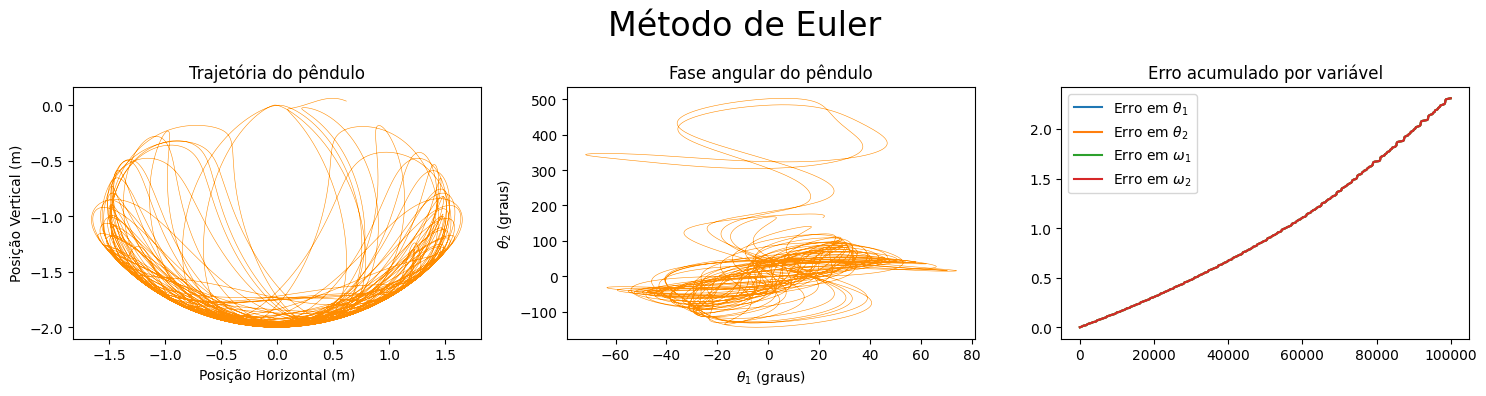

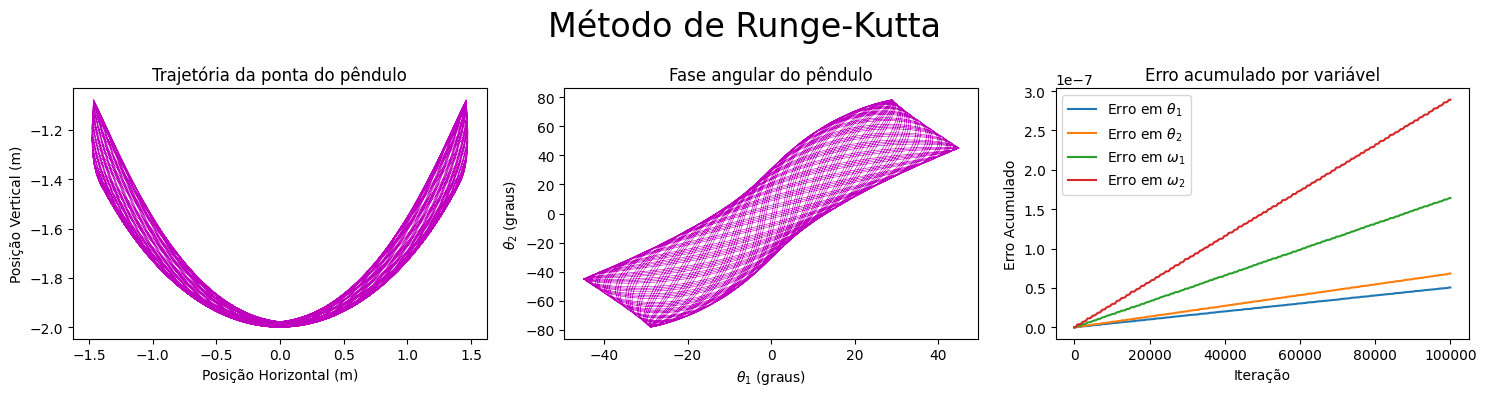

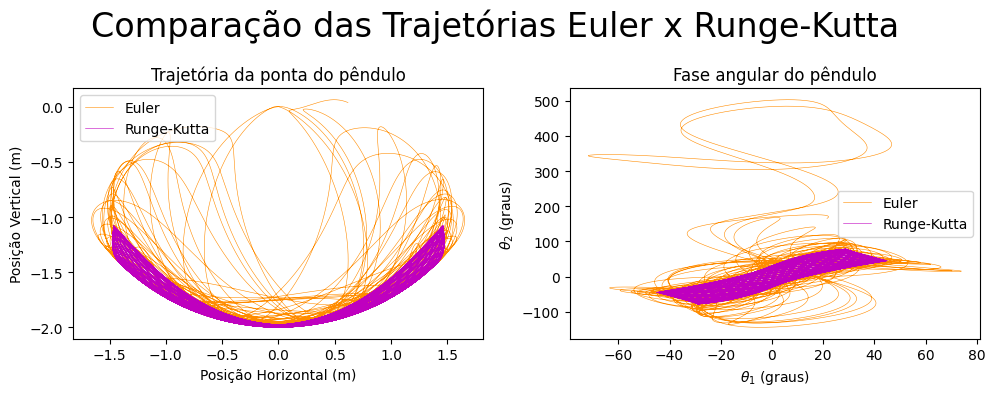

In [6]:
############
# GRÁFICOS #
############

'''
Nesta seção são criados três gráficos diferentes. 
    1) Método de Euler
    2) Método de Runge-Kutta-Fehlberg
    3) Gráfico comparativos
Os gráficos 1 e 2 apresentam a trajetória do pêndulo, fase angular de cada pêndulo e
erro de cada variável.
O gráfico 3 apresenta a trajetória e a fase angular sobrepostas.
'''

# Gráfico 1, dividido em 3 subplots
plt.figure(figsize=(15,4))
plt.suptitle("Método de Euler", fontsize = 24)
plt.subplot(1,3,1)
plt.title("Trajetória do pêndulo")
plt.plot(x2_e,y2_e, lw = 0.4, color = "darkorange")
plt.xlabel("Posição Horizontal (m)")
plt.ylabel("Posição Vertical (m)")


plt.subplot(1,3,2)
plt.title("Fase angular do pêndulo")
plt.plot(e_theta1_listg, e_theta2_listg, color = "darkorange", lw = 0.4)
plt.xlabel(r"$\theta _1$ (graus)")
plt.ylabel(r"$\theta _2$ (graus)")

plt.subplot(1,3,3)
plt.title("Erro acumulado por variável")
plt.plot(e_R_list1, label = r"Erro em $\theta _1$")
plt.plot(e_R_list2, label = r"Erro em $\theta _2$")
plt.plot(e_R_list3, label = r"Erro em $\omega _1$")
plt.plot(e_R_list4, label = r"Erro em $\omega _2$")
plt.tight_layout()
plt.legend()


# Gráfico 2, dividido em 3 subplots
plt.figure(figsize =(15,4))
plt.suptitle("Método de Runge-Kutta", fontsize = 24)
plt.subplot(1,3,1)
plt.title("Trajetória da ponta do pêndulo")
plt.plot(x2_rk,y2_rk, lw = 0.4, color = "m")
plt.xlabel("Posição Horizontal (m)")
plt.ylabel("Posição Vertical (m)")

plt.subplot(1,3,2)
plt.title("Fase angular do pêndulo")
plt.plot(rk_theta1_listg, rk_theta2_listg, color = "m", lw = 0.4)
plt.xlabel(r"$\theta _1$ (graus)")
plt.ylabel(r"$\theta _2$ (graus)")

plt.subplot(1,3,3)
plt.title("Erro acumulado por variável")
plt.plot(rk_R_list1, label = r"Erro em $\theta _1$")
plt.plot(rk_R_list2, label = r"Erro em $\theta _2$")
plt.plot(rk_R_list3, label = r"Erro em $\omega _1$")
plt.plot(rk_R_list4, label = r"Erro em $\omega _2$")
plt.xlabel("Iteração")
plt.ylabel("Erro Acumulado")
plt.tight_layout()
plt.legend()


# Gráfico 3, dividido em 2 subplots
plt.figure(figsize =(10,4))
plt.suptitle("Comparação das Trajetórias Euler x Runge-Kutta", fontsize = 24)

plt.subplot(1,2,1)
plt.title("Trajetória da ponta do pêndulo")
plt.plot(x2_e,y2_e, "darkorange", lw = 0.4, label = "Euler")
plt.plot(x2_rk,y2_rk, "m", lw =0.4, label = "Runge-Kutta")
plt.xlabel("Posição Horizontal (m)")
plt.ylabel("Posição Vertical (m)")
plt.legend()

plt.subplot(1,2,2)
plt.title("Fase angular do pêndulo")
plt.plot(e_theta1_listg, e_theta2_listg, color = "darkorange", lw = 0.4, label = "Euler")
plt.plot(rk_theta1_listg, rk_theta2_listg, color = "m", lw = 0.4, label = "Runge-Kutta")
plt.xlabel(r"$\theta _1$ (graus)")
plt.ylabel(r"$\theta _2$ (graus)")
plt.legend()
plt.tight_layout()



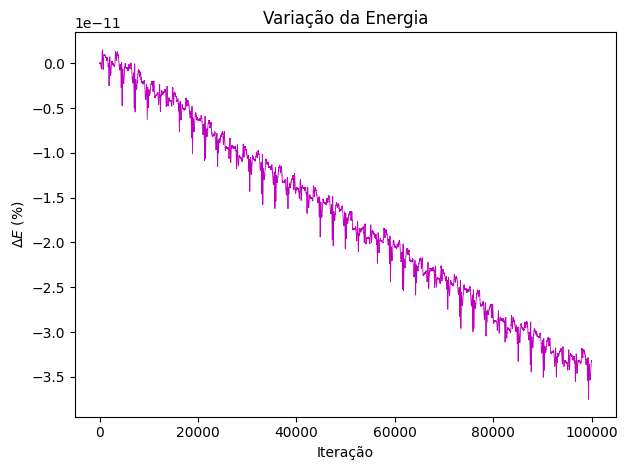

In [7]:
######################
# GRÁFICO DA ENERGIA #
######################

''' 
O sistema do pêndulo duplo analisado pressupõe conservação de energia.
Um método numérico "perfeito" não deveria resultar em flutuações de energia, de modo que
    essa variação reflete o erro do nosso modelo.
Dessa forma, acompanhar a variação da energia para cada instante reflete na "saúde" de nosso modelo.
'''

plt.plot(En_rk, color = "m", lw = 0.6)
plt.title("Variação da Energia")
plt.ylabel(r"$\Delta E$ (%)")
plt.xlabel("Iteração")
plt.tight_layout()


In [9]:
'''
Abaixo configura-se uma rápida animação dos resultados obtidos pelo RKF realizado anteriormente.
'''

from IPython.display import HTML # Módulo para mostrar a simulação no Output do notebook.

MovieWriter ffmpeg unavailable; using Pillow instead.


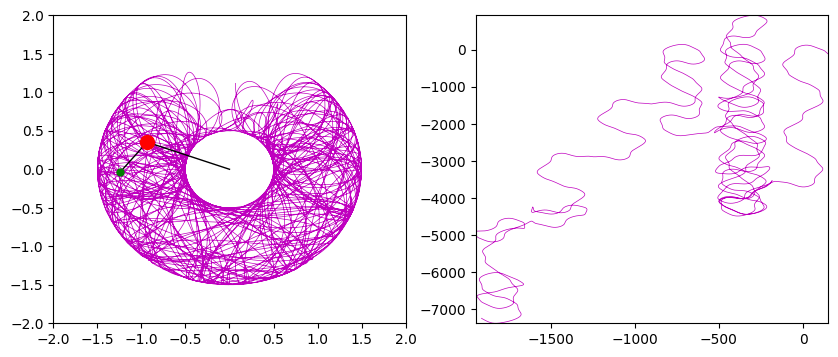

In [ ]:
# A animação usa o matplotlib.animation. Abaixo cria-se o framework  da animação.
# Será animado, ao mesmo tempo, o movimento do pêndulo e o diagrama de fase.
fig, axis = plt.subplots(1,2,figsize=(10, 4))
quadros = len(x1_rk) # O número de quadros totais é o número total de iterações realizadas.

############################
# CONFIGURAÇÕES DO PÊNDULO #
############################

# Idealmente os limites dos eixos x e y devem ser iguais para a trajetória ser fisicamente proporcional
# Como a maior distância do (0,0) é a soma do comprimento dos dois fios, os limites pode ser ajustados
    # para se adaptar ao tamanho do fio definido no início do código.
axis[0].set_ylim([-2,2]) 
axis[0].set_xlim([-2,2])

animated_plot, = axis[0].plot([], [], "m", lw=0.5) # Trajetória do pêndulo


string_plot, = axis[0].plot([], [], '-', color='k', lw=1.0)  # Fio que conecta as massas

pend1_plot, = axis[0].plot([],[],'o',color = "r", markersize = m1*10) # Massa 1
pend2_plot, = axis[0].plot([],[],'o',color = "g", markersize = m2*10) # Massa 2

########################
# CONFIGURAÇÕES DA FASE #
########################

fase_plot, = axis[1].plot([],[], "m", lw=0.5) # Diferença de fase

# Como diferentes valores iniciais resultam em fases muitos distintas, o tamanho dos eixos
    # está atuomatizado para os valores máximos e mínimos dos ângulos dos pêndulos.
axis[1].set_xlim([min(rk_theta1_listg[0:quadros]),max(rk_theta1_listg[0:quadros])])
axis[1].set_ylim([min(rk_theta2_listg[0:quadros]),max(rk_theta2_listg[0:quadros])])

# Atualização dos frames
'''
Para o fio e as massas só queremos a posição atual deles. Assim cada atualização deve plotar
    a posição anterior e atual do pêndulo (não é possível colocar somente a posição instantânea).
Para as trajetórias é interessante manter as posições anteriores, para formar o desenho completo
'''
def update_data(frame):
    animated_plot.set_data(x2_rk[:frame], y2_rk[:frame])

    string_plot.set_data(
        [0, x1_rk[frame-1], x2_rk[frame-1]],
        [0, y1_rk[frame-1], y2_rk[frame-1]]
    )

    pend1_plot.set_data(x1_rk[frame-1:frame], y1_rk[frame-1:frame])
    pend2_plot.set_data(x2_rk[frame-1:frame], y2_rk[frame-1:frame])

    fase_plot.set_data(rk_theta1_listg[:frame], rk_theta2_listg[:frame])
    
    # Essa função retorna cada um dos conjuntos de dados que devem ser plotados para cada frame
    # O resultado é inserido na função FuncAnimation do matplotlib, abaixo.
    return animated_plot,string_plot, pend1_plot, pend2_plot, fase_plot

'''
Sobre a animação: Como todo o sistema está no S.I., tecnicamente o tempo da animação é o tempo 
real do movimento do pêndulo. Caso você queira que a animação siga o tempo real é necessário realizar
um cálculo que considera o seu passo (h), o número de frames e o intervalo entre cada frame.

EXEMPLO: Defini que h = 0.001s e vou simular o dado a cada 100 iterações (pegar cada iteração seria muito
    pesado). Assim, entre cada frame temos t = 0.001 x 100 = 0.1s. Isso significa que o intervalo entre
    cada frame é de 100 ms. Por isso, a minha variável "interval" (que define o intervalo entre cada
    atualização da animação) deve ser de 100ms e, caso eu exporte em .gif devo colocar fps = 10)
'''
animation = FuncAnimation(
    fig = fig,
    func = update_data,
    frames = range(0,quadros,100), # Estou pegando todo o intervalo de simulação
    # Você pode mudar o range para pegar partes específicas da simulação.
    interval = 100,
    blit = True
)

HTML(animation.to_jshtml())
animation.save("Caos.gif", fps = 10) # Se quiser ver no output é necessário comentar essa linha.